In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# For Figures in Results Section about d18O signal at WDC and what drives it
## End results are figures of the T2M response to SAM, PSA1, PSA2 (by quartile differences) with contours of the T2M field with psuedoWDC d18O record

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_Submission_30Apr2020'

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA_TAGGED.nc')
CTRL_DATA

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    tp            (time, lat, lon) float32 ...
    ci            (time, lat, lon) float32 ...
    d18O          (time, lat, lon) float32 ...
    d18O_Atl_05   (time, lat, lon) float32 ...
    d18O_Atl_15   (time, lat, lon) float32 ...
    d18O_Atl_25   (time, lat, lon) float32 ...
    d18O_Atl_35   (time, lat, lon) float32 ...
    d18O_Atl_45   (time, lat, lon) float32 ...
    d18O_

In [4]:
#getting variables in right units 
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

In [5]:
#sst_tmon_ctrl

In [6]:
#Open pandas dfs of all indices and ASL information
pdo_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_tmon.pkl')
# pdo_index_ctrl.head(n=5)
pdo_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_seas.pkl')
# pdo_seas_mean_index_ctrl.head(n=5)
pdo_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_ann_mean.pkl')
# pdo_ann_mean_index_ctrl.head(n=5)

soi_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_tmon.pkl')
# soi_index_ctrl.head(n=5)
soi_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_seas.pkl')
# soi_seas_mean_index_ctrl.head(n=5)
soi_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_ann_mean.pkl')
# soi_ann_mean_index_ctrl.head(n=5)
soi_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_12roll_mean.pkl')
# soi_12roll_mean_index_ctrl.head(n=10)
soi_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_6roll_mean.pkl')
# soi_6roll_mean_index_ctrl.head(n=5)
soi_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_3roll_mean.pkl')
# soi_3roll_mean_index_ctrl.head(n=5)
soi_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_band_filt.pkl')
# soi_band_filt_index_ctrl.head(n=5)

nino34_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_tmon.pkl')
# nino34_index_ctrl.head(n=5)
nino34_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_seas.pkl')
# nino34_seas_mean_index_ctrl.head(n=5)
nino34_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_ann_mean.pkl')
# nino34_ann_mean_index_ctrl.head(n=5)
nino34_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_12roll_mean.pkl')
# nino34_12roll_mean_index_ctrl.head(n=10)
nino34_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_6roll_mean.pkl')
# nino34_6roll_mean_index_ctrl.head(n=5)
nino34_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_3roll_mean.pkl')
# nino34_3roll_mean_index_ctrl.head(n=5)
nino34_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_band_filt.pkl')
# nino34_band_filt_index_ctrl.head(n=5)

enso_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_tmon.pkl')
# enso_indices_ctrl.head(n=5)
enso_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_seas.pkl')
# enso_seas_mean_indices_ctrl.head(n=5)
enso_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_ann_mean.pkl')
# enso_ann_mean_indices_ctrl.head(n=5)
enso_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_12roll_mean.pkl')
# enso_12roll_mean_indices_ctrl.head(n=10)
enso_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_6roll_mean.pkl')
# enso_6roll_mean_indices_ctrl.head(n=5)
enso_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_3roll_mean.pkl')
# enso_3roll_mean_indices_ctrl.head(n=5)
enso_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_band_filt.pkl')
# enso_band_filt_indices_ctrl.head(n=5)

SAM_PSAs_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_tmon.pkl')
# SAM_PSAs_indices_ctrl.head(n=5)
SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_ctrl.head(n=5)
SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))
SAM_PSAs_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_ctrl.head(n=10)
SAM_PSAs_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_ctrl.head(n=5)

df_d18O_psuedoWDC_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_tmon.pkl')
# df_d18O_psuedoWDC_tmon_ctrl.head(n=5)
d18O_psuedoWDC_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_seas.pkl')
# d18O_psuedoWDC_seas_mean_ctrl.head(n=5)
d18O_psuedoWDC_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_ann_mean.pkl')
# d18O_psuedoWDC_ann_mean_ctrl.head(n=5)
d18O_psuedoWDC_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_12roll_mean.pkl')
# d18O_psuedoWDC_12roll_mean_ctrl.head(n=10)
d18O_psuedoWDC_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_6roll_mean.pkl')
# d18O_psuedoWDC_6roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_3roll_mean.pkl')
# d18O_psuedoWDC_3roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_band_filt.pkl')
# d18O_psuedoWDC_band_filt_ctrl.head(n=5)

# df_d18O_psuedowestcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_ctrl.head(n=5)
# d18O_psuedowestcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_ctrl.head(n=5)
# d18O_psuedowestcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_ctrl.head(n=5)
# d18O_psuedowestcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedowestcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_ctrl.head(n=5)

# df_d18O_psuedoeastcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_ctrl.head(n=5)
# d18O_psuedoeastcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedoeastcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_ctrl.head(n=5)

# d18O_wais_pcs_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_ctrl.head(n=5)
# d18O_wais_pcs_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_ctrl.head(n=5)
# d18O_wais_pcs_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_ctrl.head(n=5)
# d18O_wais_pcs_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_ctrl.head(n=12)
# d18O_wais_pcs_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_ctrl.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Rel_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_ctrl.head(n=5)
# Rel_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_ctrl.head(n=5)
# Rel_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_ctrl.head(n=10)
# Rel_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_ctrl.head(n=5)
# Rel_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_ctrl.head(n=5)
# Rel_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_ctrl.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Abs_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_ctrl.head(n=5)
# Abs_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_ctrl.head(n=5)
# Abs_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_ctrl.head(n=10)
# Abs_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_ctrl.head(n=5)
# Abs_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_ctrl.head(n=5)
# Abs_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_ctrl.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_ctrl_tagged_df.head(n=5)
Rel_CP_djf_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)
Rel_CP_mam_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_ctrl.head(n=5)
Rel_CP_jja_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_ctrl.head(n=5)
Rel_CP_son_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_ctrl.head(n=5)
Rel_CP_ann_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_ann_mean.pkl')
print(Rel_CP_ann_mean_indices_raw_ctrl.head(n=5))
Rel_CP_12roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_12roll_mean.pkl')
# Rel_CP_12roll_mean_indices_raw_ctrl.head(n=10)
Rel_CP_6roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_6roll_mean.pkl')
# Rel_CP_6roll_mean_indices_raw_ctrl.head(n=5)
Rel_CP_3roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_ctrl.head(n=5)
# Rel_CP_band_filt_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_ctrl.head(n=5)


                 SAM      PSA1      PSA2
time                                    
1702-01-01 -0.311936 -0.015404  0.094802
1703-01-01 -0.819279  0.553104  0.060246
1704-01-01 -0.714730  0.496267 -0.208190
1705-01-01 -0.431827  0.106548 -0.660348
1706-01-01  0.391807 -0.572466  0.115213
                vals       lats   lons  sectormean  indice
time                                                      
1702-01-01 -5.477830 -71.052632  197.5  986.772813       0
1703-01-01 -5.095673 -71.052632  195.0  989.296173       1
1704-01-01 -4.715917 -71.052632  205.0  989.053075       2
1705-01-01 -7.214285 -71.052632  205.0  987.087820       3
1706-01-01 -6.000570 -71.052632  207.5  982.878988       4


In [7]:
#Adding Abs CP column to Rel_CP dataframe
Rel_CP_djf_mean_indices_raw_ctrl['abs_vals'] = (Rel_CP_djf_mean_indices_raw_ctrl.vals + Rel_CP_djf_mean_indices_raw_ctrl.sectormean)
Rel_CP_mam_mean_indices_raw_ctrl['abs_vals'] = (Rel_CP_mam_mean_indices_raw_ctrl.vals + Rel_CP_mam_mean_indices_raw_ctrl.sectormean)
Rel_CP_jja_mean_indices_raw_ctrl['abs_vals'] = (Rel_CP_jja_mean_indices_raw_ctrl.vals + Rel_CP_jja_mean_indices_raw_ctrl.sectormean)
Rel_CP_son_mean_indices_raw_ctrl['abs_vals'] = (Rel_CP_son_mean_indices_raw_ctrl.vals + Rel_CP_son_mean_indices_raw_ctrl.sectormean)
Rel_CP_ann_mean_indices_raw_ctrl['abs_vals'] = (Rel_CP_ann_mean_indices_raw_ctrl.vals + Rel_CP_ann_mean_indices_raw_ctrl.sectormean)
Rel_CP_ann_mean_indices_raw_ctrl

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1702-01-01,-5.477830,-71.052632,197.5,986.772813,0,981.294983
1703-01-01,-5.095673,-71.052632,195.0,989.296173,1,984.200500
1704-01-01,-4.715917,-71.052632,205.0,989.053075,2,984.337158
1705-01-01,-7.214285,-71.052632,205.0,987.087820,3,979.873535
1706-01-01,-6.000570,-71.052632,207.5,982.878988,4,976.878418
1707-01-01,-5.013147,-72.947368,202.5,988.179468,5,983.166321
1708-01-01,-6.237241,-72.947368,200.0,986.348752,6,980.111511
1709-01-01,-4.708475,-74.842105,202.5,985.381021,7,980.672546
1710-01-01,-7.355555,-71.052632,212.5,983.823085,8,976.467529


## PART I: Full record 0002-0076 Spatial Correlations between T2M field and pseudoWDC d18O



### Detrending and removing climatology from the pseudoWDC d18O Record

In [8]:
#params to be set
time_lo     = '1702-01-01'
time_hi    = '1776-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = -20 #Had to reverse hi and lo lat values for ERA
shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [9]:
#monthly pseudoWDC, raw and detrended into dataframes
xr_pseudoWDC_tmon_ctrl = d18O_tmon_ctrl.sel(time=slice(time_lo, time_hi)).sel(lat=-78.63, lon=247.5, method='nearest')

d = {'time': xr_pseudoWDC_tmon_ctrl.coords['time'], 'd18O': xr_pseudoWDC_tmon_ctrl.values}
df_pseudoWDC_tmon_ctrl = pd.DataFrame(data=d)
df_pseudoWDC_tmon_ctrl.set_index('time', inplace=True, drop=True)
# df_pseudoWDC_tmon_ctrl


d = {'time': xr_pseudoWDC_tmon_ctrl.coords['time'], 'd18O': signal.detrend(xr_pseudoWDC_tmon_ctrl.values)}
df_pseudoWDC_tmon_detrend_ctrl = pd.DataFrame(data=d)
df_pseudoWDC_tmon_detrend_ctrl.set_index('time', inplace=True, drop=True)
df_pseudoWDC_tmon_detrend_ctrl.head(n=5)


,d18O
time,
1702-01-31,3.883675
1702-02-28,-1.150978
1702-03-31,3.594955
1702-04-30,-1.887924
1702-05-31,-1.771187


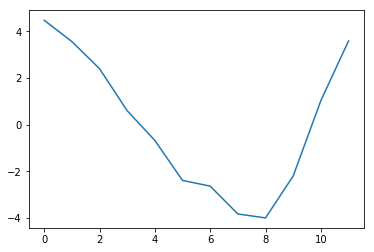

,d18O
month,
1,2.607348
2,2.036469
3,1.213943
4,-0.247617
5,-1.181461
6,-2.554456
7,-2.459228
8,-3.311077
9,-3.139694


In [10]:
#Create df of detrended psuedoWDC d18O record on monthly intevals from 000201-007612 WITH CLIMATOLOGY REMOVED

#Remove climatology second, see below, works best to change into xr data array first
#xarray
da_pseudoWDC_000201_007612_detrend_ctrl = xr.DataArray(df_pseudoWDC_tmon_detrend_ctrl.d18O.values, coords={'time': df_pseudoWDC_tmon_detrend_ctrl.index}, dims=('time'))
da_pseudoWDC_000201_007612_detrend_ctrl

#calculate climatology
da_pseudoWDC_000201_007612_detrend_climatology_ctrl = da_pseudoWDC_000201_007612_detrend_ctrl.groupby('time.month').mean('time')
plt.plot(da_pseudoWDC_000201_007612_detrend_climatology_ctrl)
plt.show()

#turn back into pd DataFrame
d = {'month': da_pseudoWDC_000201_007612_detrend_climatology_ctrl.coords['month'], 'd18O': signal.detrend(da_pseudoWDC_000201_007612_detrend_climatology_ctrl.values)}
df_pseudoWDC_tmon_detrend_climatology_ctrl = pd.DataFrame(data=d)
df_pseudoWDC_tmon_detrend_climatology_ctrl.set_index('month', inplace=True, drop=True)
df_pseudoWDC_tmon_detrend_climatology_ctrl

# See that the min is in Aug, Should ask Tyler if he can move the minimum in WDC to August?

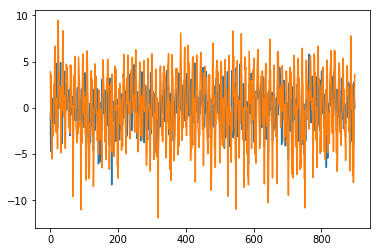

,time,d18O
time,,
1702-01-31,1702-01-31,-0.597254
1702-02-28,1702-02-28,-4.720377
1702-03-31,1702-03-31,1.188734
1702-04-30,1702-04-30,-2.491934
1702-05-31,1702-05-31,-1.100702


In [11]:
#remove climatology
da_pseudoWDC_000201_007612_detrend_anoms_ctrl = da_pseudoWDC_000201_007612_detrend_ctrl.groupby('time.month') - da_pseudoWDC_000201_007612_detrend_climatology_ctrl

plt.plot(da_pseudoWDC_000201_007612_detrend_anoms_ctrl)
plt.plot(da_pseudoWDC_000201_007612_detrend_ctrl)
plt.show()

#turn back into pd DataFrame
d = {'time': da_pseudoWDC_000201_007612_detrend_ctrl['time'], 'd18O': da_pseudoWDC_000201_007612_detrend_anoms_ctrl.values}
df_pseudoWDC_000201_007612_detrend_anoms_ctrl = pd.DataFrame(data=d)
df_pseudoWDC_000201_007612_detrend_anoms_ctrl.set_index(df_pseudoWDC_000201_007612_detrend_anoms_ctrl['time'], inplace=True, drop=True)
df_pseudoWDC_000201_007612_detrend_anoms_ctrl.head(n=5)


### Detrending and removing climatology for the T2M variable. (Not using the normalized data here)


In [12]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1702-01-01'
time_hi    = '1776-12-31' 

#Define the Tropical Pacific per Jeong et al., (2017)
trop_pac_xhi = 290
trop_pac_xlo = 110
trop_pac_yhi = 20 
trop_pac_ylo = -20  

asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -59.6 
asl_ylo_slice = -80 

shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
shem_xlo_slice = 0
shem_yhi_slice = -45 
shem_ylo_slice = -90 

shem_yhi = -20 
shem_ylo = -90  

In [13]:
t2m_shem_tmon_ctrl = t2m_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem t2m; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended t2m data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(t2m_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': t2m_shem_tmon_ctrl.coords['time'], 'lat': t2m_shem_tmon_ctrl.coords['lat'],'lon': t2m_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

t2m_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)

#Create t2m Monthly Climatology from detrended data using data from time_lo to time_hi
t2m_detrend_shem_climatology_ctrl = t2m_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# t2m_detrend_shem_climatology_ctrl

#Find Southern Hemisphere t2m Anoms using the climatology from time_lo to time_hi
t2m_anoms_shem_tmon_detrend_ctrl = t2m_shem_tmon_detrend_ctrl.groupby('time.month') - t2m_detrend_shem_climatology_ctrl


#In case I eventually want to use the normalized dataset, here it is:
#Normalize Southern Hemisphere t2m Anoms (from detrended data)
t2m_anoms_shem_tmon_detrend_norm_ctrl = (t2m_anoms_shem_tmon_detrend_ctrl - t2m_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/t2m_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# t2m_anoms_shem_tmon_detrend_norm_ctrl


In [14]:
#Xarray of detrended T2M anomalies from 000201-007612 (monthly)
t2m_anoms_000201_007612_tmon_detrend_ctrl = t2m_anoms_shem_tmon_detrend_ctrl
t2m_anoms_000201_007612_tmon_detrend_ctrl

#Xarray of detrended T2M raw from 000201-007612 (monthly)
t2m_000201_007612_tmon_detrend_ctrl = t2m_shem_tmon_detrend_ctrl
t2m_000201_007612_tmon_detrend_ctrl

<xarray.DataArray (time: 900, lat: 37, lon: 144)>
array([[[17.16935 , 17.204853, ..., 17.176796, 17.2084  ],
        [18.197575, 18.418243, ..., 17.828697, 18.063412],
        ...,
        [ 1.603724,  1.696602, ...,  1.469807,  1.526747],
        [ 1.398214,  1.556561, ...,  1.231783,  1.288933]],

       [[ 9.899502,  9.939106, ...,  9.912769,  9.929852],
        [10.619717, 10.674133, ..., 10.507183, 10.574345],
        ...,
        [ 2.678886,  2.59766 , ...,  2.747187,  2.715975],
        [ 2.451227,  2.418222, ...,  2.45479 ,  2.453175]],

       ...,

       [[ 9.316227,  9.326981, ...,  9.313614,  9.322147],
        [ 9.101524,  9.116756, ...,  9.026257,  9.07098 ],
        ...,
        [-0.750206, -0.723921, ..., -0.547344, -0.68984 ],
        [-0.76391 , -0.698666, ..., -0.602987, -0.711699]],

       [[15.005974, 14.966064, ..., 14.934792, 14.951832],
        [15.980335, 16.076641, ..., 15.670715, 15.863815],
        ...,
        [ 0.207617,  0.294693, ...,  0.193871,  0.188

### Turn monthly data (pseudoWDC d18O record and T2M array) into Seasons and Annual Mean

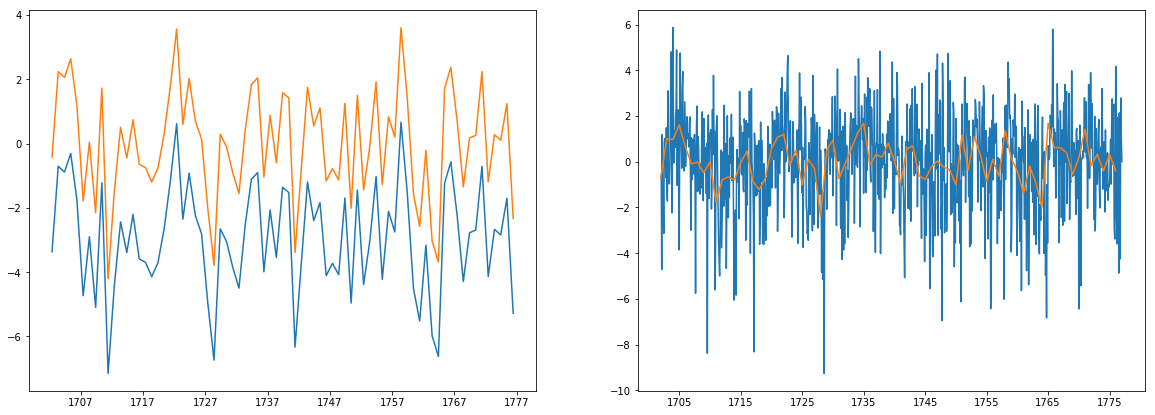

In [15]:
# pseudoWDC Seasonal Means:
# Pulling out the Seasonal Time Series and Seasonal ANOM Time Series

# df_pseudoWDC_tmon_detrend_ctrl
# df_pseudoWDC_000201_007612_detrend_anoms_ctrl

#seasonal means from monthly data
df_pseudoWDC_seas_0002_0076_detrend_ctrl = df_pseudoWDC_tmon_detrend_ctrl[2:(len(df_pseudoWDC_tmon_detrend_ctrl.index)-1)].resample('3MS', closed='left'  ).mean()
df_pseudoWDC_seas_0002_0076_detrend_ctrl['Seas_Index'] = df_pseudoWDC_seas_0002_0076_detrend_ctrl.index.astype(str).str[5:7]
df_pseudoWDC_seas_0002_0076_detrend_ctrl

df_pseudoWDC_djf_0002_0076_detrend_ctrl = df_pseudoWDC_seas_0002_0076_detrend_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_ctrl.Seas_Index == '12').dropna()
df_pseudoWDC_mam_0002_0076_detrend_ctrl = df_pseudoWDC_seas_0002_0076_detrend_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_ctrl.Seas_Index == '03').dropna()
df_pseudoWDC_jja_0002_0076_detrend_ctrl = df_pseudoWDC_seas_0002_0076_detrend_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_ctrl.Seas_Index == '06').dropna()
df_pseudoWDC_son_0002_0076_detrend_ctrl = df_pseudoWDC_seas_0002_0076_detrend_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_ctrl.Seas_Index == '09').dropna()

#seasonal means of anoms
df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl = df_pseudoWDC_000201_007612_detrend_anoms_ctrl[2:(len(df_pseudoWDC_000201_007612_detrend_anoms_ctrl.index)-1)].resample('3MS', closed='left'  ).mean()
df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl['Seas_Index'] = df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.index.astype(str).str[5:7]

df_pseudoWDC_djf_0002_0076_detrend_anoms_ctrl = df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.Seas_Index == '12').dropna()
df_pseudoWDC_mam_0002_0076_detrend_anoms_ctrl = df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.Seas_Index == '03').dropna()
df_pseudoWDC_jja_0002_0076_detrend_anoms_ctrl = df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.Seas_Index == '06').dropna()
df_pseudoWDC_son_0002_0076_detrend_anoms_ctrl = df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.where(df_pseudoWDC_seas_0002_0076_detrend_anoms_ctrl.Seas_Index == '09').dropna()


plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(df_pseudoWDC_jja_0002_0076_detrend_ctrl.d18O)
plt.plot(df_pseudoWDC_jja_0002_0076_detrend_anoms_ctrl.d18O)
# plt.show()
# Removing the climatology does not change pattern, only centers variability about zero
# Will use the data with climatology removed


# pseudoWDC Annual Mean:
df_pseudoWDC_ann_mean_0002_0076_detrend_anoms_ctrl = df_pseudoWDC_000201_007612_detrend_anoms_ctrl.resample('AS', closed='left').mean()
plt.subplot(1,2,2)
plt.plot(df_pseudoWDC_000201_007612_detrend_anoms_ctrl.d18O)
plt.plot(df_pseudoWDC_ann_mean_0002_0076_detrend_anoms_ctrl.d18O)
plt.show()
# # Annual cycle looks good

In [16]:
# T2M field in Seasonal Means:
# NOTE, T2M SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH

rolls_for_seas = t2m_anoms_000201_007612_tmon_detrend_ctrl.rolling(time=3, min_periods=3, center=True).mean()
djf_t2m_anoms_0002_0076_detrend_ctrl = rolls_for_seas[12::12,:]
mam_t2m_anoms_0002_0076_detrend_ctrl = rolls_for_seas[3::12,:]
jja_t2m_anoms_0002_0076_detrend_ctrl = rolls_for_seas[6::12,:]
son_t2m_anoms_0002_0076_detrend_ctrl = rolls_for_seas[9::12,:]


#T2M field in Annual Mean:
#Note, time is now list of years 0002, 1980, etc  (not in yyyy-mm-dd)
ann_mean_t2m_anoms_0002_0076_detrend_ctrl = t2m_anoms_000201_007612_tmon_detrend_ctrl.groupby('time.year').mean('time')
ann_mean_t2m_anoms_0002_0076_detrend_ctrl.coords['year']

<xarray.DataArray 'year' (year: 75)>
array([1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713,
       1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725,
       1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737,
       1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749,
       1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761,
       1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773,
       1774, 1775, 1776])
Coordinates:
  * year     (year) int64 1702 1703 1704 1705 1706 ... 1772 1773 1774 1775 1776

### Correlate the pseudoWDC time series with T2M field for each season and annual mean -- to get to spatial correlation map with significance contours 

#### calculate the correlation of every row in a 2D array to a 1D array of the same length
#### https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
#### x is 1D, m
#### y is 2D, nXm with second dimension equal in length to length of x, m

In [17]:
#DJF 
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
djf_t2m_anoms_0002_0076_detrend_stack_ctrl = djf_t2m_anoms_0002_0076_detrend_ctrl.stack(xy=('lat', 'lon'))
print(djf_t2m_anoms_0002_0076_detrend_stack_ctrl.shape)

x = df_pseudoWDC_djf_0002_0076_detrend_anoms_ctrl['d18O'].values
y = djf_t2m_anoms_0002_0076_detrend_stack_ctrl.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
djf_t2m_anoms_0002_0076_detrend_stack_ctrl['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. Make sure girls are watching so someone can be really impressed with what you're doing.
djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl = djf_t2m_anoms_0002_0076_detrend_stack_ctrl.unstack('xy')[0]


#MAM
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
mam_t2m_anoms_0002_0076_detrend_stack_ctrl = mam_t2m_anoms_0002_0076_detrend_ctrl.stack(xy=('lat', 'lon'))
print(mam_t2m_anoms_0002_0076_detrend_stack_ctrl.shape)

x = df_pseudoWDC_mam_0002_0076_detrend_anoms_ctrl['d18O'].values
y = mam_t2m_anoms_0002_0076_detrend_stack_ctrl.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
mam_t2m_anoms_0002_0076_detrend_stack_ctrl['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. Make sure girls are watching so someone can be really impressed with what you're doing.
mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl = mam_t2m_anoms_0002_0076_detrend_stack_ctrl.unstack('xy')[0]


#JJA
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
jja_t2m_anoms_0002_0076_detrend_stack_ctrl = jja_t2m_anoms_0002_0076_detrend_ctrl.stack(xy=('lat', 'lon'))
print(jja_t2m_anoms_0002_0076_detrend_stack_ctrl.shape)

x = df_pseudoWDC_jja_0002_0076_detrend_anoms_ctrl['d18O'].values
y = jja_t2m_anoms_0002_0076_detrend_stack_ctrl.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
jja_t2m_anoms_0002_0076_detrend_stack_ctrl['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. Make sure girls are watching so someone can be really impressed with what you're doing.
jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl = jja_t2m_anoms_0002_0076_detrend_stack_ctrl.unstack('xy')[0]


#SON
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
son_t2m_anoms_0002_0076_detrend_stack_ctrl = son_t2m_anoms_0002_0076_detrend_ctrl.stack(xy=('lat', 'lon'))
print(son_t2m_anoms_0002_0076_detrend_stack_ctrl.shape)

x = df_pseudoWDC_son_0002_0076_detrend_anoms_ctrl['d18O'].values
y = son_t2m_anoms_0002_0076_detrend_stack_ctrl.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
son_t2m_anoms_0002_0076_detrend_stack_ctrl['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. Make sure girls are watching so someone can be really impressed with what you're doing.
son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl = son_t2m_anoms_0002_0076_detrend_stack_ctrl.unstack('xy')[0]


#Annual Mean
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
ann_mean_t2m_anoms_0002_0076_detrend_stack_ctrl = ann_mean_t2m_anoms_0002_0076_detrend_ctrl.stack(xy=('lat', 'lon'))
print(ann_mean_t2m_anoms_0002_0076_detrend_stack_ctrl.shape)

x = df_pseudoWDC_ann_mean_0002_0076_detrend_anoms_ctrl['d18O'].values
y = ann_mean_t2m_anoms_0002_0076_detrend_stack_ctrl.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearann_means = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearann_mean corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
ann_mean_t2m_anoms_0002_0076_detrend_stack_ctrl['pearsons'] = (('xy'), pearann_means)

# Unstack `xy` back into lat, lon. Make sure girls are watching so someone can be really impressed with what you're doing.
ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl = ann_mean_t2m_anoms_0002_0076_detrend_stack_ctrl.unstack('xy')[0]


(74, 5328)
(74,) (5328, 74)
(75, 5328)
(75,) (5328, 75)
(75, 5328)
(75,) (5328, 75)
(75, 5328)
(75,) (5328, 75)
(75, 5328)
(75,) (5328, 75)


In [18]:
#Table of critical r value for the Pearson Correlation to be significant at 0.05, 
#For New Scale: years 0002-0076
ann_sigs_n75 = 0.230
seas_sigs_n75 = 0.230
djf_sigs_n74 = 0.230

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


pseudoWDC d18O Record Corr. with T2M DJF = 0.382


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


pseudoWDC d18O Record Corr. with T2M MAM = 0.696


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


pseudoWDC d18O Record Corr. with T2M JJA = 0.788


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


pseudoWDC d18O Record Corr. with T2M SON = 0.792


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


pseudoWDC d18O Record Corr. with T2M Annual Mean = 0.799


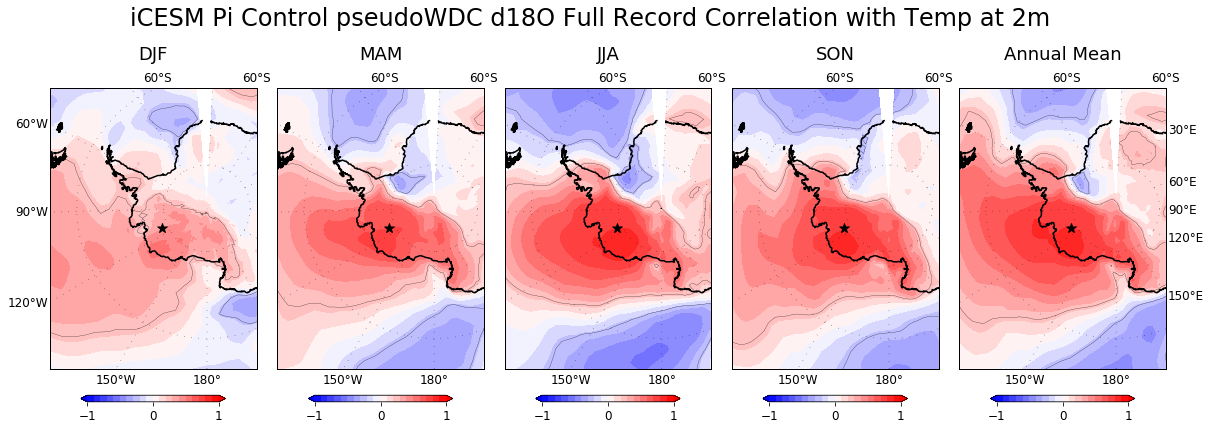

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM Pi Control pseudoWDC d18O Full Record Correlation with Temp at 2m', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1,1.1,.1)

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
siglevs = [(-1)*djf_sigs_n74, djf_sigs_n74]
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)

print('pseudoWDC d18O Record Corr. with T2M DJF =', np.round_(djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))


#MAM
siglevs = [(-1)*seas_sigs_n75, seas_sigs_n75]
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)

print('pseudoWDC d18O Record Corr. with T2M MAM =', np.round_(mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))


#JJA
siglevs = [(-1)*seas_sigs_n75, seas_sigs_n75]
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)

print('pseudoWDC d18O Record Corr. with T2M JJA =', np.round_(jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))


#SON
siglevs = [(-1)*seas_sigs_n75, seas_sigs_n75]
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)

print('pseudoWDC d18O Record Corr. with T2M SON =', np.round_(son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))



#Annual Mean
siglevs = [(-1)*ann_sigs_n75, ann_sigs_n75]
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)

print('pseudoWDC d18O Record Corr. with T2M Annual Mean =', np.round_(ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))


# plt.savefig(FIG_PATH+'/iCESM_Pi_Control_TAGGED_pseudoWDC_d18O_corr_with_t2m_Field_0002_0076_11Feb2019.ps',bbox_inches='tight', pad_inches=0.02)


plt.show()



### Select correlation values that are significant (bounded between -0.23 and 0.23)

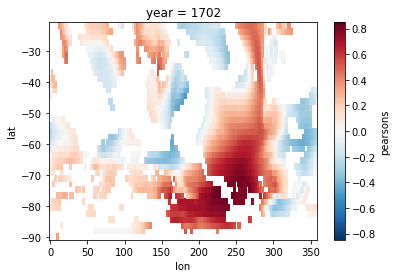

In [20]:
djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_bounded = djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.where(
    (djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl >= 0.23) | (djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl <= -0.23))
mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_bounded = mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.where(
    (mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl >= 0.23) | (mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl <= -0.23))
jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_bounded = jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.where(
    (jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl >= 0.23) | (jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl <= -0.23))
son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_bounded = son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.where(
    (son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl >= 0.23) | (son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl <= -0.23))
ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_bounded = ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.where(
    (ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl >= 0.23) | (ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl <= -0.23))
ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_bounded.plot()

## PART 2: Full record 0002-0076 Quartile Difference between T2M field and pseudoWDC d18O



In [21]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1776-12-31' 

# trop_pac_xhi = 290
# trop_pac_xlo = 110
# trop_pac_yhi = 20 
# trop_pac_ylo = -20  

# asl_xhi_slice = 298
# asl_xlo_slice = 170
# asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# asl_ylo_slice = -80

# shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# shem_xlo_slice = 0
# shem_yhi_slice = -45
# shem_ylo_slice = -90

shem_yhi = -20 #Need to reverse hi and lo lat values for ERA
shem_ylo = -90  #Need to reverse hi and lo lat values for ERA

In [22]:
t2m_shem_tmon_ctrl = t2m_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem t2m; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended t2m data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(t2m_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': t2m_shem_tmon_ctrl.coords['time'], 'lat': t2m_shem_tmon_ctrl.coords['lat'],'lon': t2m_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

t2m_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# t2m_shem_tmon_detrend_ctrl


#In case I eventually want the d180 to have climatology removed and normalized, that is done below
#Create t2m Monthly Climatology from detrended data using data from time_lo to time_hi
t2m_detrend_shem_climatology_ctrl = t2m_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# t2m_detrend_shem_climatology_ctrl

#Find Southern Hemisphere t2m Anoms using the climatology from time_lo to time_hi
t2m_anoms_shem_tmon_detrend_ctrl = t2m_shem_tmon_detrend_ctrl.groupby('time.month') - t2m_detrend_shem_climatology_ctrl

#Normalize Southern Hemisphere t2m Anoms (from detrended data)
t2m_anoms_shem_tmon_detrend_norm_ctrl = (t2m_anoms_shem_tmon_detrend_ctrl - t2m_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/t2m_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# t2m_anoms_shem_tmon_detrend_norm_ctrl


### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile SAM across the 5 time periods

### Calculate the significance of the difference and mark with contours 

In [23]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.219990,-0.596517,-0.301634,03
1702-06-01,-0.800785,0.550760,0.381762,06
1702-09-01,-1.044955,-0.446088,0.032278,09
1702-12-01,0.218712,1.209736,0.065640,12
1703-03-01,-0.405918,0.024571,0.250692,03


#### Change Field variable into seasonal means and rolls and annual mean

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


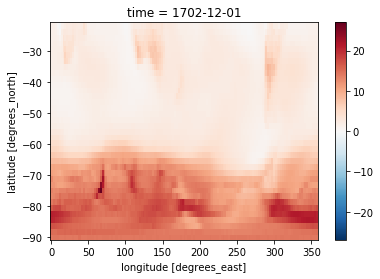

In [24]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
t2m_shem_seas_mean_detrend_ctrl = t2m_shem_tmon_detrend_ctrl[2:(len(t2m_shem_tmon_detrend_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
t2m_shem_seas_mean_detrend_ctrl[3].plot()

<xarray.DataArray (time: 74, lat: 37, lon: 144)>
array([[[14.281543, 14.314441, ..., 14.287262, 14.316185],
        [15.116107, 15.213891, ..., 14.831874, 15.010396],
        ...,
        [ 1.468269,  1.564369, ...,  1.374068,  1.414199],
        [ 1.412378,  1.516576, ...,  1.2472  ,  1.319695]],

       [[14.31245 , 14.360959, ..., 14.328945, 14.358624],
        [15.047901, 15.353179, ..., 14.629215, 14.863147],
        ...,
        [ 1.207581,  1.21473 , ...,  1.266702,  1.214555],
        [ 1.063299,  1.049652, ...,  1.083113,  1.057784]],

       ...,

       [[13.373822, 13.349383, ..., 13.326898, 13.336289],
        [13.760433, 13.988902, ..., 13.421242, 13.622878],
        ...,
        [ 1.502041,  1.549348, ...,  1.510405,  1.49022 ],
        [ 1.353696,  1.429373, ...,  1.268389,  1.297613]],

       [[13.529773, 13.491863, ..., 13.462178, 13.474524],
        [13.99609 , 14.190137, ..., 13.695006, 13.869214],
        ...,
        [ 1.246206,  1.288413, ...,  1.255587,  1.2453

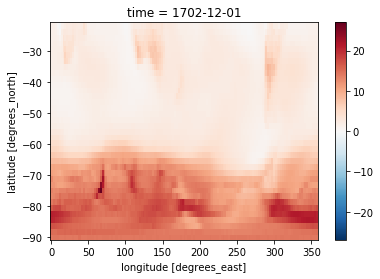

In [25]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_t2m_shem_seas_mean_detrend_ctrl = t2m_shem_seas_mean_detrend_ctrl.sel(time=is_djf(t2m_shem_seas_mean_detrend_ctrl['time.month']))
mam_t2m_shem_seas_mean_detrend_ctrl = t2m_shem_seas_mean_detrend_ctrl.sel(time=is_mam(t2m_shem_seas_mean_detrend_ctrl['time.month']))
jja_t2m_shem_seas_mean_detrend_ctrl = t2m_shem_seas_mean_detrend_ctrl.sel(time=is_jja(t2m_shem_seas_mean_detrend_ctrl['time.month']))
son_t2m_shem_seas_mean_detrend_ctrl = t2m_shem_seas_mean_detrend_ctrl.sel(time=is_son(t2m_shem_seas_mean_detrend_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_t2m_shem_seas_mean_detrend_ctrl[0].plot()
print(djf_t2m_shem_seas_mean_detrend_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

In [26]:
#Field variable with 3,6,12 roll and annual mean

t2m_shem_ann_mean_detrend_ctrl = t2m_shem_tmon_detrend_ctrl.resample(time='AS').mean(axis=0)
#t2m_shem_ann_mean_detrend_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [27]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_ctrl = pd.DataFrame(data=d)
# SAM_djf_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_ctrl = pd.DataFrame(data=d)
# SAM_mam_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_ctrl = pd.DataFrame(data=d)
# SAM_jja_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
SAM_son_mean_ctrl = pd.DataFrame(data=d)
# SAM_son_mean_ctrl

d = {'SAM': SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna()),1)}
SAM_ann_mean_ctrl = pd.DataFrame(data=d)
# SAM_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_ctrl
SAM_djf_mean_upper_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_ctrl

SAM_mam_mean_lower_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_ctrl
SAM_mam_mean_upper_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_ctrl

SAM_jja_mean_lower_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_ctrl
SAM_jja_mean_upper_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_ctrl

SAM_son_mean_lower_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_ctrl
SAM_son_mean_upper_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_ctrl

SAM_ann_mean_lower_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_ctrl
SAM_ann_mean_upper_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_upper_ctrl

In [28]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_upper_SAM_detrend_ctrl = djf_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_t2m_w_lower_SAM_detrend_ctrl = djf_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_t2m_w_upper_SAM_detrend_ctrl
# djf_t2m_w_lower_SAM_detrend_ctrl

#mam
mam_t2m_w_upper_SAM_detrend_ctrl = mam_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_t2m_w_lower_SAM_detrend_ctrl = mam_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_t2m_w_upper_SAM_detrend_ctrl
# mam_t2m_w_lower_SAM_detrend_ctrl

#jja
jja_t2m_w_upper_SAM_detrend_ctrl = jja_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_t2m_w_lower_SAM_detrend_ctrl = jja_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_t2m_w_upper_SAM_detrend_ctrl
# jja_t2m_w_lower_SAM_detrend_ctrl

#son
son_t2m_w_upper_SAM_detrend_ctrl = son_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_t2m_w_lower_SAM_detrend_ctrl = son_t2m_shem_seas_mean_detrend_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_t2m_w_upper_SAM_detrend_ctrl
# son_t2m_w_lower_SAM_detrend_ctrl

#ann mean
ann_mean_t2m_w_upper_SAM_detrend_ctrl = t2m_shem_ann_mean_detrend_ctrl.isel(time = SAM_ann_mean_upper_ctrl)
ann_mean_t2m_w_lower_SAM_detrend_ctrl = t2m_shem_ann_mean_detrend_ctrl.isel(time = SAM_ann_mean_lower_ctrl)
# ann_mean_t2m_w_upper_SAM_detrend_ctrl
# ann_mean_t2m_w_lower_SAM_detrend_ctrl


In [29]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl
djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_lower_ctrl]
print(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl)

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl
mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl
jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_SAM_detrend_ctrl
son_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl



                vals       lats   lons  sectormean  indice    abs_vals
time                                                                  
1746-12-01 -4.958054 -67.263158  210.0  996.012071      44  991.054016
1740-12-01 -3.807089 -59.684211  285.0  997.261008      38  993.453918
1738-12-01 -2.207881 -65.368421  267.5  995.975032      36  993.767151
1773-12-01 -1.683833 -59.684211  270.0  995.767390      71  994.083557
1757-12-01 -4.844033 -61.578947  267.5  993.280373      55  988.436340
1704-12-01 -3.187957 -65.368421  277.5  993.587920       2  990.399963
1714-12-01 -3.531904 -69.157895  192.5  994.265730      12  990.733826
1729-12-01 -3.591308 -63.473684  275.0  993.789245      27  990.197937
1731-12-01 -4.569136 -65.368421  265.0  994.691511      29  990.122375
1758-12-01 -4.659740 -65.368421  287.5  992.567943      56  987.908203
1743-12-01 -5.189118 -61.578947  295.0  993.503265      41  988.314148
1770-12-01 -3.458809 -69.157895  277.5  991.809456      68  988.350647
1707-1

In [30]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_SAM_ttest_stats_ctrl, djf_t2m_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    djf_t2m_w_upper_SAM_detrend_ctrl, djf_t2m_w_lower_SAM_detrend_ctrl, axis=0)

mam_t2m_change_due_to_SAM_ttest_stats_ctrl, mam_t2m_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    mam_t2m_w_upper_SAM_detrend_ctrl, mam_t2m_w_lower_SAM_detrend_ctrl, axis=0)

jja_t2m_change_due_to_SAM_ttest_stats_ctrl, jja_t2m_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    jja_t2m_w_upper_SAM_detrend_ctrl, jja_t2m_w_lower_SAM_detrend_ctrl, axis=0)

son_t2m_change_due_to_SAM_ttest_stats_ctrl, son_t2m_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    son_t2m_w_upper_SAM_detrend_ctrl, son_t2m_w_lower_SAM_detrend_ctrl, axis=0)

ann_mean_t2m_change_due_to_SAM_ttest_stats_ctrl, ann_mean_t2m_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    ann_mean_t2m_w_upper_SAM_detrend_ctrl, ann_mean_t2m_w_lower_SAM_detrend_ctrl, axis=0)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-4.9006856442428495 -4.334664159718601


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.9532959019987315 -6.00313496077386


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.416681147344788 -8.54199293308687


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-8.127777513028976 -7.011836237000317


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.386607262488048 -5.541187217482436


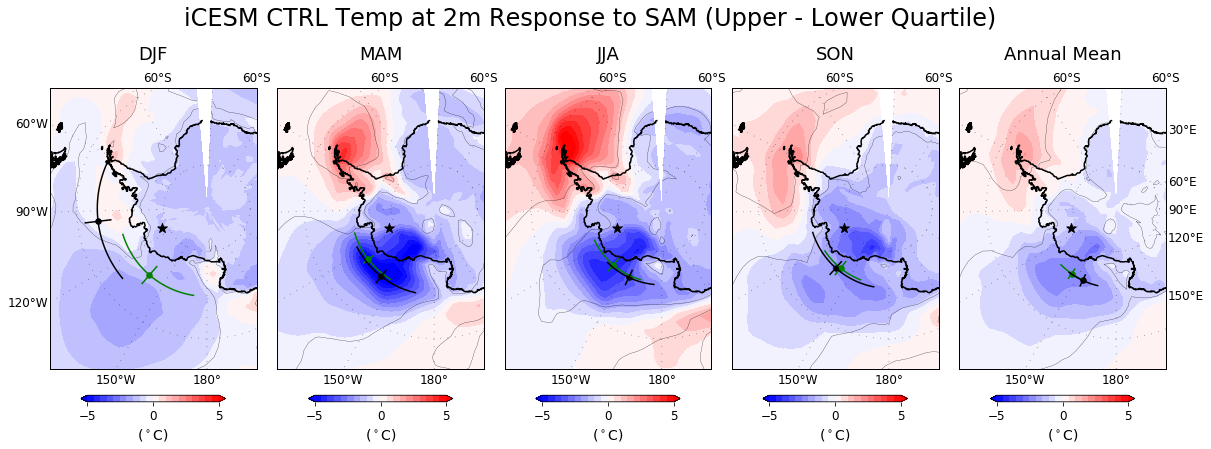

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Temp at 2m Response to SAM (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((djf_t2m_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (djf_t2m_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(djf_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_change_due_to_SAM_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((mam_t2m_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (mam_t2m_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(mam_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_change_due_to_SAM_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((jja_t2m_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (jja_t2m_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(jja_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_change_due_to_SAM_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((son_t2m_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (son_t2m_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(son_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_change_due_to_SAM_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((ann_mean_t2m_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_t2m_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(ann_mean_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_change_due_to_SAM_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/iCESM_CTRL_TAGGED_t2m_Field_vs_SAM_Quartiles_24Jan2019.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

### Select quartile difference values that are significant (bounded between [-2.028,2.028] for all seasons and annual mean)

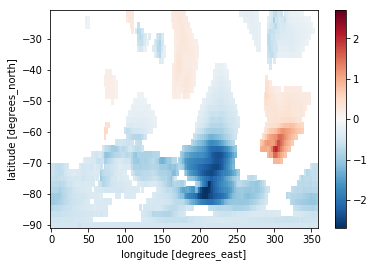

In [32]:
djf_t2m_quart_diff_due_to_SAM_ctrl = (djf_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0))
djf_t2m_quart_diff_due_to_SAM_ctrl_bounded = djf_t2m_quart_diff_due_to_SAM_ctrl.where((djf_t2m_change_due_to_SAM_ttest_stats_ctrl <= -2.028) | (djf_t2m_change_due_to_SAM_ttest_stats_ctrl >= 2.028))
mam_t2m_quart_diff_due_to_SAM_ctrl = (mam_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0))
mam_t2m_quart_diff_due_to_SAM_ctrl_bounded = mam_t2m_quart_diff_due_to_SAM_ctrl.where((mam_t2m_change_due_to_SAM_ttest_stats_ctrl <= -2.028) | (mam_t2m_change_due_to_SAM_ttest_stats_ctrl >= 2.028))
jja_t2m_quart_diff_due_to_SAM_ctrl = (jja_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0))
jja_t2m_quart_diff_due_to_SAM_ctrl_bounded = jja_t2m_quart_diff_due_to_SAM_ctrl.where((jja_t2m_change_due_to_SAM_ttest_stats_ctrl <= -2.028) | (jja_t2m_change_due_to_SAM_ttest_stats_ctrl >= 2.028))
son_t2m_quart_diff_due_to_SAM_ctrl = (son_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0))
son_t2m_quart_diff_due_to_SAM_ctrl_bounded = son_t2m_quart_diff_due_to_SAM_ctrl.where((son_t2m_change_due_to_SAM_ttest_stats_ctrl <= -2.028) | (son_t2m_change_due_to_SAM_ttest_stats_ctrl >= 2.028))
ann_mean_t2m_quart_diff_due_to_SAM_ctrl = (ann_mean_t2m_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_ctrl.mean(axis=0))
ann_mean_t2m_quart_diff_due_to_SAM_ctrl_bounded = ann_mean_t2m_quart_diff_due_to_SAM_ctrl.where((ann_mean_t2m_change_due_to_SAM_ttest_stats_ctrl <= -2.028) | (ann_mean_t2m_change_due_to_SAM_ttest_stats_ctrl >= 2.028))
ann_mean_t2m_quart_diff_due_to_SAM_ctrl_bounded.plot()

## PART 3.1: Finalize Figure - For SAM, T2M, and pseudoWDC d18O



/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


981.1935255262587 989.5328742133247


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


974.5008994654605 980.9824507863898


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


972.2143297697369 981.6682289525082


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


971.3132002981085 979.1874453895971


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


977.1731760125411 982.0548031455592
-1.108
-2.146
-2.054
-2.384
-1.137


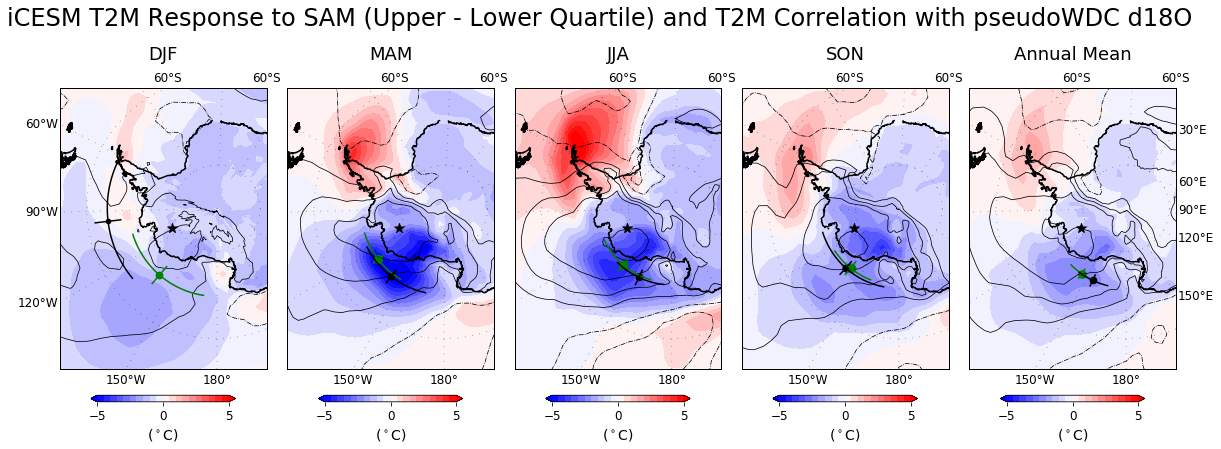

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM T2M Response to SAM (Upper - Lower Quartile) and T2M Correlation with pseudoWDC d18O', fontsize=24, y=1.05)

#Remove Pizza slice in variables
djf_t2m_quart_diff_due_to_SAM_ctrl_fin, lons = addcyclic(djf_t2m_quart_diff_due_to_SAM_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
mam_t2m_quart_diff_due_to_SAM_ctrl_fin, lons = addcyclic(mam_t2m_quart_diff_due_to_SAM_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
jja_t2m_quart_diff_due_to_SAM_ctrl_fin, lons = addcyclic(jja_t2m_quart_diff_due_to_SAM_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
son_t2m_quart_diff_due_to_SAM_ctrl_fin, lons = addcyclic(son_t2m_quart_diff_due_to_SAM_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
ann_mean_t2m_quart_diff_due_to_SAM_ctrl_fin, lons = addcyclic(ann_mean_t2m_quart_diff_due_to_SAM_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

# setup Lambert Conformal basemap.
lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
# levels_contour = [-.230,.230] #good for seasons and annual mean
# levels_contour = [-.93,-.83,-.73,-.63,-.53,-.43,-.33,-.23,.23,.33,.43,.53,.63,.73,.83,.93] #adding additional contours
levels_contour = [-1,-.8,-.6,-.4,-.2,.2,.4,.6,.8,1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'dashdot'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_quart_diff_due_to_SAM_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=60) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_quart_diff_due_to_SAM_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())
                
     
#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_quart_diff_due_to_SAM_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())        
        
        
        
 #SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_quart_diff_due_to_SAM_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())


 
#Annual
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_quart_diff_due_to_SAM_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.abs_vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.abs_vals.mean())    
    
plt.savefig(FIG_PATH+'/Figure_iCESM_Pi_Control_Section_2_Figure_T2M_pseudoWDC_and_SAM_0002_0076_Multi-Contours_01May2020.ps',bbox_inches='tight', pad_inches=0.02)    
   
#print field variable quart diff at WDC location
print(np.round_(djf_t2m_quart_diff_due_to_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(mam_t2m_quart_diff_due_to_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(jja_t2m_quart_diff_due_to_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(son_t2m_quart_diff_due_to_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(ann_mean_t2m_quart_diff_due_to_SAM_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
    
    
plt.show()

## PART 2.2: Full record 0002-0076 Quartile Difference between T2M field and PSA1



### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile PSA1 across the 5 time periods

### Calculate the significance of the difference and mark with contours 

In [34]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.219990,-0.596517,-0.301634,03
1702-06-01,-0.800785,0.550760,0.381762,06
1702-09-01,-1.044955,-0.446088,0.032278,09
1702-12-01,0.218712,1.209736,0.065640,12
1703-03-01,-0.405918,0.024571,0.250692,03


In [35]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA1_djf_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA1_mam_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA1_jja_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_ctrl = pd.DataFrame(data=d)
# PSA1_son_mean_ctrl

d = {'PSA1': SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna()),1)}
PSA1_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA1_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_ctrl
PSA1_djf_mean_upper_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_ctrl

PSA1_mam_mean_lower_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_ctrl
PSA1_mam_mean_upper_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_ctrl

PSA1_jja_mean_lower_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_ctrl
PSA1_jja_mean_upper_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_ctrl

PSA1_son_mean_lower_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_ctrl
PSA1_son_mean_upper_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_ctrl

PSA1_ann_mean_lower_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_ctrl
PSA1_ann_mean_upper_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_ctrl

In [36]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_upper_PSA1_detrend_ctrl = djf_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_t2m_w_lower_PSA1_detrend_ctrl = djf_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# djf_t2m_w_upper_PSA1_detrend_ctrl
# djf_t2m_w_lower_PSA1_detrend_ctrl

#mam
mam_t2m_w_upper_PSA1_detrend_ctrl = mam_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_t2m_w_lower_PSA1_detrend_ctrl = mam_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_t2m_w_upper_PSA1_detrend_ctrl
# mam_t2m_w_lower_PSA1_detrend_ctrl

#jja
jja_t2m_w_upper_PSA1_detrend_ctrl = jja_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_t2m_w_lower_PSA1_detrend_ctrl = jja_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_t2m_w_upper_PSA1_detrend_ctrl
# jja_t2m_w_lower_PSA1_detrend_ctrl

#son
son_t2m_w_upper_PSA1_detrend_ctrl = son_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_t2m_w_lower_PSA1_detrend_ctrl = son_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
son_t2m_w_upper_PSA1_detrend_ctrl
# son_t2m_w_lower_PSA1_detrend_ctrl

#ann mean
ann_mean_t2m_w_upper_PSA1_detrend_ctrl = t2m_shem_ann_mean_detrend_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_t2m_w_lower_PSA1_detrend_ctrl = t2m_shem_ann_mean_detrend_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_t2m_w_upper_PSA1_detrend_ctrl
# ann_mean_t2m_w_lower_PSA1_detrend_ctrl


In [37]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl



In [38]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_PSA1_ttest_stats_ctrl, djf_t2m_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_t2m_w_upper_PSA1_detrend_ctrl, djf_t2m_w_lower_PSA1_detrend_ctrl, axis=0)

mam_t2m_change_due_to_PSA1_ttest_stats_ctrl, mam_t2m_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_t2m_w_upper_PSA1_detrend_ctrl, mam_t2m_w_lower_PSA1_detrend_ctrl, axis=0)

jja_t2m_change_due_to_PSA1_ttest_stats_ctrl, jja_t2m_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_t2m_w_upper_PSA1_detrend_ctrl, jja_t2m_w_lower_PSA1_detrend_ctrl, axis=0)

son_t2m_change_due_to_PSA1_ttest_stats_ctrl, son_t2m_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_t2m_w_upper_PSA1_detrend_ctrl, son_t2m_w_lower_PSA1_detrend_ctrl, axis=0)

ann_mean_t2m_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_t2m_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_t2m_w_upper_PSA1_detrend_ctrl, ann_mean_t2m_w_lower_PSA1_detrend_ctrl, axis=0)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.106986103323708 -4.515817744437799


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.229096456814222 -7.534570793525045


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-9.024108736384415 -8.221795111436869


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-8.02506695740981 -7.543635169409012


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.138386531665141 -5.635352124021916


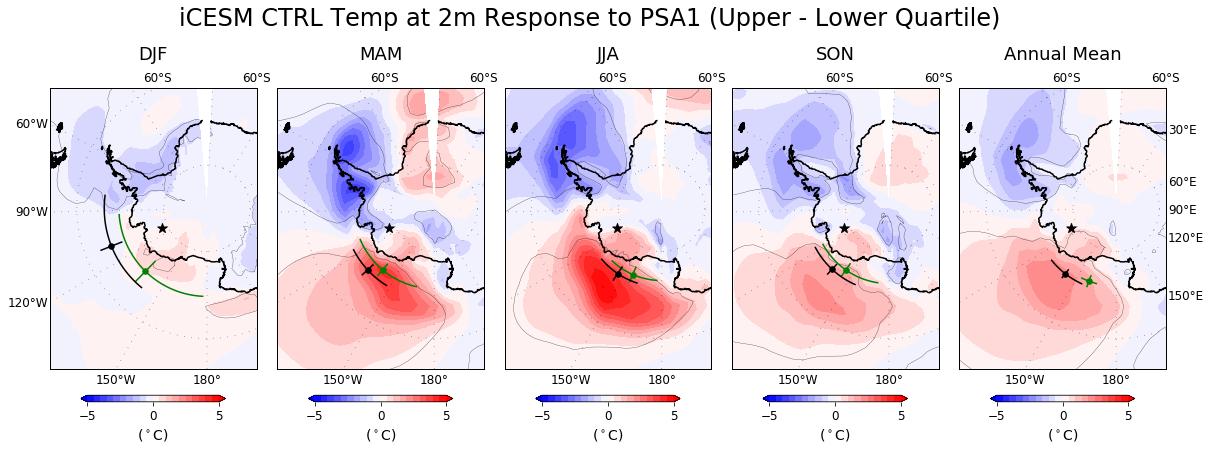

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Temp at 2m Response to PSA1 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((djf_t2m_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (djf_t2m_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(djf_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_change_due_to_PSA1_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((mam_t2m_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (mam_t2m_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(mam_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_change_due_to_PSA1_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((jja_t2m_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (jja_t2m_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(jja_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_change_due_to_PSA1_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((son_t2m_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (son_t2m_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(son_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_change_due_to_PSA1_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((ann_mean_t2m_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_t2m_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_change_due_to_PSA1_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/iCESM_CTRL_TAGGED_t2m_Field_vs_PSA1_Quartiles_24Jan2019.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

### Select quartile difference values that are significant (bounded between [-2.028,2.028] for all seasons and annual mean)

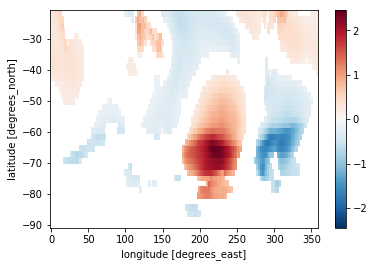

In [40]:
djf_t2m_quart_diff_due_to_PSA1_ctrl = (djf_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0))
djf_t2m_quart_diff_due_to_PSA1_ctrl_bounded = djf_t2m_quart_diff_due_to_PSA1_ctrl.where((djf_t2m_change_due_to_PSA1_ttest_stats_ctrl <= -2.028) | (djf_t2m_change_due_to_PSA1_ttest_stats_ctrl >= 2.028))
mam_t2m_quart_diff_due_to_PSA1_ctrl = (mam_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0))
mam_t2m_quart_diff_due_to_PSA1_ctrl_bounded = mam_t2m_quart_diff_due_to_PSA1_ctrl.where((mam_t2m_change_due_to_PSA1_ttest_stats_ctrl <= -2.028) | (mam_t2m_change_due_to_PSA1_ttest_stats_ctrl >= 2.028))
jja_t2m_quart_diff_due_to_PSA1_ctrl = (jja_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0))
jja_t2m_quart_diff_due_to_PSA1_ctrl_bounded = jja_t2m_quart_diff_due_to_PSA1_ctrl.where((jja_t2m_change_due_to_PSA1_ttest_stats_ctrl <= -2.028) | (jja_t2m_change_due_to_PSA1_ttest_stats_ctrl >= 2.028))
son_t2m_quart_diff_due_to_PSA1_ctrl = (son_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0))
son_t2m_quart_diff_due_to_PSA1_ctrl_bounded = son_t2m_quart_diff_due_to_PSA1_ctrl.where((son_t2m_change_due_to_PSA1_ttest_stats_ctrl <= -2.028) | (son_t2m_change_due_to_PSA1_ttest_stats_ctrl >= 2.028))
ann_mean_t2m_quart_diff_due_to_PSA1_ctrl = (ann_mean_t2m_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_ctrl.mean(axis=0))
ann_mean_t2m_quart_diff_due_to_PSA1_ctrl_bounded = ann_mean_t2m_quart_diff_due_to_PSA1_ctrl.where((ann_mean_t2m_change_due_to_PSA1_ttest_stats_ctrl <= -2.028) | (ann_mean_t2m_change_due_to_PSA1_ttest_stats_ctrl >= 2.028))
ann_mean_t2m_quart_diff_due_to_PSA1_ctrl_bounded.plot()

## PART 3.2: Finalize Figure - For PSA1, T2M, and pseudoWDC d18O



/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


983.7607760959202 984.8945719401041


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


979.0541124845806 975.3926327354029


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


979.4516665810033 975.7227237099096


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


976.8627126593339 973.4583162006579


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


980.7444939864309 978.9656982421875
0.115
-0.498
0.16
0.05
0.25


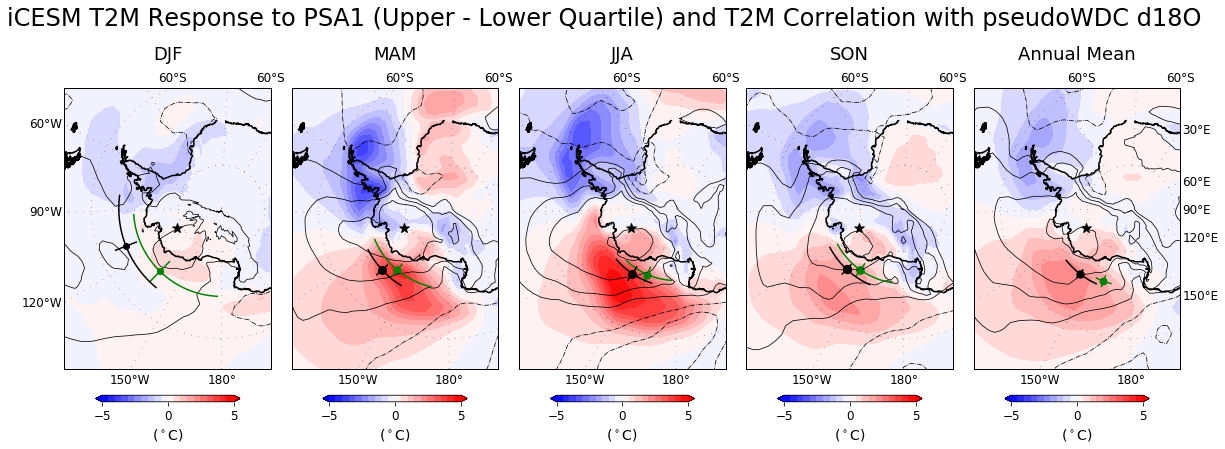

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM T2M Response to PSA1 (Upper - Lower Quartile) and T2M Correlation with pseudoWDC d18O', fontsize=24, y=1.05)

#Remove Pizza slice in variables
djf_t2m_quart_diff_due_to_PSA1_ctrl_fin, lons = addcyclic(djf_t2m_quart_diff_due_to_PSA1_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
mam_t2m_quart_diff_due_to_PSA1_ctrl_fin, lons = addcyclic(mam_t2m_quart_diff_due_to_PSA1_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
jja_t2m_quart_diff_due_to_PSA1_ctrl_fin, lons = addcyclic(jja_t2m_quart_diff_due_to_PSA1_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
son_t2m_quart_diff_due_to_PSA1_ctrl_fin, lons = addcyclic(son_t2m_quart_diff_due_to_PSA1_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
ann_mean_t2m_quart_diff_due_to_PSA1_ctrl_fin, lons = addcyclic(ann_mean_t2m_quart_diff_due_to_PSA1_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

# setup Lambert Conformal basemap.
lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
# levels_contour = [-.230,.230] #good for seasons and annual mean
# levels_contour = [-.93,-.83,-.73,-.63,-.53,-.43,-.33,-.23,.23,.33,.43,.53,.63,.73,.83,.93] #adding additional contours
levels_contour = [-1,-.8,-.6,-.4,-.2,.2,.4,.6,.8,1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'dashdot'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_quart_diff_due_to_PSA1_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_quart_diff_due_to_PSA1_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())
                
     
#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_quart_diff_due_to_PSA1_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())        
        
        
        
 #SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_quart_diff_due_to_PSA1_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())


 
#Annual
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_quart_diff_due_to_PSA1_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.abs_vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.abs_vals.mean())    
    
plt.savefig(FIG_PATH+'/Figure_iCESM_Pi_Control_Section_2_Figure_T2M_pseudoWDC_and_PSA1_0002_0076_Multi-Contours_01May2020.ps',bbox_inches='tight', pad_inches=0.02)    
 
#print field variable quart diff at WDC location
print(np.round_(djf_t2m_quart_diff_due_to_PSA1_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(mam_t2m_quart_diff_due_to_PSA1_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(jja_t2m_quart_diff_due_to_PSA1_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(son_t2m_quart_diff_due_to_PSA1_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(ann_mean_t2m_quart_diff_due_to_PSA1_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
        
    
plt.show()

## PART 2.3: Full record 0002-0076 Quartile Difference between T2M field and PSA2



### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile PSA2 across the 5 time periods

### Calculate the significance of the difference and mark with contours 

In [42]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.219990,-0.596517,-0.301634,03
1702-06-01,-0.800785,0.550760,0.381762,06
1702-09-01,-1.044955,-0.446088,0.032278,09
1702-12-01,0.218712,1.209736,0.065640,12
1703-03-01,-0.405918,0.024571,0.250692,03


In [43]:
#Find PSA2 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA2_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA2_djf_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA2_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA2_mam_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA2_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA2_jja_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA2_son_mean_ctrl = pd.DataFrame(data=d)
# PSA2_son_mean_ctrl

d = {'PSA2': SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna()),1)}
PSA2_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA2_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA2'
#Note, head is lower (sorted from low to high)
PSA2_djf_mean_lower_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_djf_mean_lower_ctrl
PSA2_djf_mean_upper_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_djf_mean_upper_ctrl

PSA2_mam_mean_lower_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_mam_mean_lower_ctrl
PSA2_mam_mean_upper_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_mam_mean_upper_ctrl

PSA2_jja_mean_lower_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_jja_mean_lower_ctrl
PSA2_jja_mean_upper_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_jja_mean_upper_ctrl

PSA2_son_mean_lower_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_son_mean_lower_ctrl
PSA2_son_mean_upper_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_son_mean_upper_ctrl

PSA2_ann_mean_lower_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_ann_mean_lower_ctrl
PSA2_ann_mean_upper_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_ann_mean_upper_ctrl

In [44]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_t2m_w_upper_PSA2_detrend_ctrl = djf_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_djf_mean_upper_ctrl)
djf_t2m_w_lower_PSA2_detrend_ctrl = djf_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_djf_mean_lower_ctrl)
# djf_t2m_w_upper_PSA2_detrend_ctrl
# djf_t2m_w_lower_PSA2_detrend_ctrl

#mam
mam_t2m_w_upper_PSA2_detrend_ctrl = mam_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_mam_mean_upper_ctrl)
mam_t2m_w_lower_PSA2_detrend_ctrl = mam_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_mam_mean_lower_ctrl)
# mam_t2m_w_upper_PSA2_detrend_ctrl
# mam_t2m_w_lower_PSA2_detrend_ctrl

#jja
jja_t2m_w_upper_PSA2_detrend_ctrl = jja_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_jja_mean_upper_ctrl)
jja_t2m_w_lower_PSA2_detrend_ctrl = jja_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_jja_mean_lower_ctrl)
# jja_t2m_w_upper_PSA2_detrend_ctrl
# jja_t2m_w_lower_PSA2_detrend_ctrl

#son
son_t2m_w_upper_PSA2_detrend_ctrl = son_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_son_mean_upper_ctrl)
son_t2m_w_lower_PSA2_detrend_ctrl = son_t2m_shem_seas_mean_detrend_ctrl.isel(time = PSA2_son_mean_lower_ctrl)
son_t2m_w_upper_PSA2_detrend_ctrl
# son_t2m_w_lower_PSA2_detrend_ctrl

#ann mean
ann_mean_t2m_w_upper_PSA2_detrend_ctrl = t2m_shem_ann_mean_detrend_ctrl.isel(time = PSA2_ann_mean_upper_ctrl)
ann_mean_t2m_w_lower_PSA2_detrend_ctrl = t2m_shem_ann_mean_detrend_ctrl.isel(time = PSA2_ann_mean_lower_ctrl)
# ann_mean_t2m_w_upper_PSA2_detrend_ctrl
# ann_mean_t2m_w_lower_PSA2_detrend_ctrl


In [45]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA2_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA2_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA2_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA2_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA2_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA2_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA2_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA2_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA2_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA2_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl



In [46]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_t2m_change_due_to_PSA2_ttest_stats_ctrl, djf_t2m_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    djf_t2m_w_upper_PSA2_detrend_ctrl, djf_t2m_w_lower_PSA2_detrend_ctrl, axis=0)

mam_t2m_change_due_to_PSA2_ttest_stats_ctrl, mam_t2m_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    mam_t2m_w_upper_PSA2_detrend_ctrl, mam_t2m_w_lower_PSA2_detrend_ctrl, axis=0)

jja_t2m_change_due_to_PSA2_ttest_stats_ctrl, jja_t2m_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    jja_t2m_w_upper_PSA2_detrend_ctrl, jja_t2m_w_lower_PSA2_detrend_ctrl, axis=0)

son_t2m_change_due_to_PSA2_ttest_stats_ctrl, son_t2m_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    son_t2m_w_upper_PSA2_detrend_ctrl, son_t2m_w_lower_PSA2_detrend_ctrl, axis=0)

ann_mean_t2m_change_due_to_PSA2_ttest_stats_ctrl, ann_mean_t2m_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    ann_mean_t2m_w_upper_PSA2_detrend_ctrl, ann_mean_t2m_w_lower_PSA2_detrend_ctrl, axis=0)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.374876643481325 -4.486435325784612


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-6.908089215714785 -8.050070780168431


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.786907935729884 -10.248190862856978


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-7.157968732370154 -8.815137848276686


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


-5.365339134086364 -6.6296034630651155


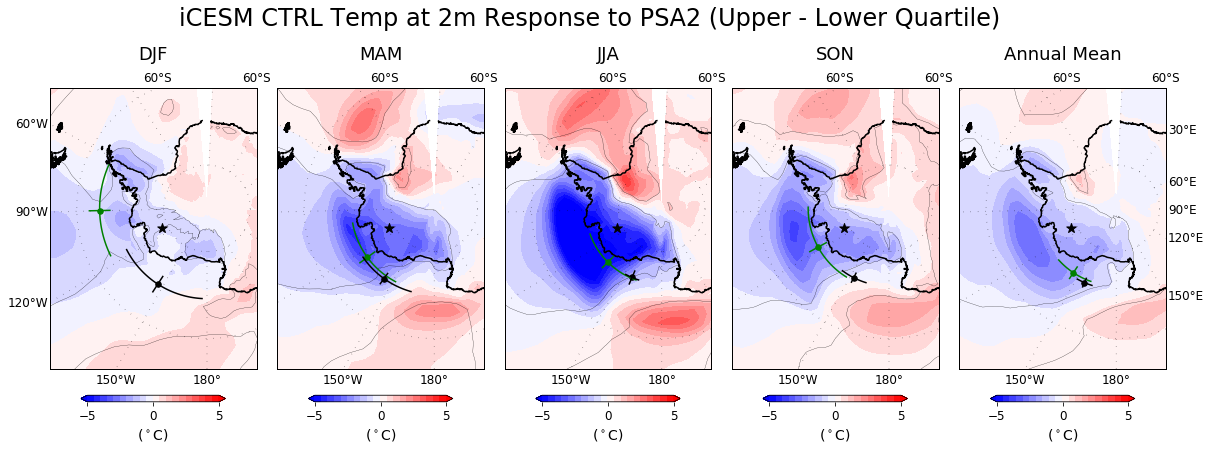

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Temp at 2m Response to PSA2 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((djf_t2m_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (djf_t2m_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(djf_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_change_due_to_PSA2_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((mam_t2m_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (mam_t2m_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(mam_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_change_due_to_PSA2_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((jja_t2m_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (jja_t2m_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(jja_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_change_due_to_PSA2_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((son_t2m_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (son_t2m_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(son_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_change_due_to_PSA2_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((ann_mean_t2m_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_t2m_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_change_due_to_PSA2_ttest_stats_ctrl,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/iCESM_CTRL_TAGGED_t2m_Field_vs_PSA2_Quartiles_24Jan2019.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

### Select quartile difference values that are significant (bounded between [-2.028,2.028] for all seasons and annual mean)

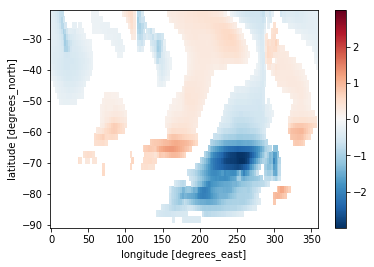

In [48]:
djf_t2m_quart_diff_due_to_PSA2_ctrl = (djf_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0))
djf_t2m_quart_diff_due_to_PSA2_ctrl_bounded = djf_t2m_quart_diff_due_to_PSA2_ctrl.where((djf_t2m_change_due_to_PSA2_ttest_stats_ctrl <= -2.028) | (djf_t2m_change_due_to_PSA2_ttest_stats_ctrl >= 2.028))
mam_t2m_quart_diff_due_to_PSA2_ctrl = (mam_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0))
mam_t2m_quart_diff_due_to_PSA2_ctrl_bounded = mam_t2m_quart_diff_due_to_PSA2_ctrl.where((mam_t2m_change_due_to_PSA2_ttest_stats_ctrl <= -2.028) | (mam_t2m_change_due_to_PSA2_ttest_stats_ctrl >= 2.028))
jja_t2m_quart_diff_due_to_PSA2_ctrl = (jja_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0))
jja_t2m_quart_diff_due_to_PSA2_ctrl_bounded = jja_t2m_quart_diff_due_to_PSA2_ctrl.where((jja_t2m_change_due_to_PSA2_ttest_stats_ctrl <= -2.028) | (jja_t2m_change_due_to_PSA2_ttest_stats_ctrl >= 2.028))
son_t2m_quart_diff_due_to_PSA2_ctrl = (son_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0))
son_t2m_quart_diff_due_to_PSA2_ctrl_bounded = son_t2m_quart_diff_due_to_PSA2_ctrl.where((son_t2m_change_due_to_PSA2_ttest_stats_ctrl <= -2.028) | (son_t2m_change_due_to_PSA2_ttest_stats_ctrl >= 2.028))
ann_mean_t2m_quart_diff_due_to_PSA2_ctrl = (ann_mean_t2m_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_ctrl.mean(axis=0))
ann_mean_t2m_quart_diff_due_to_PSA2_ctrl_bounded = ann_mean_t2m_quart_diff_due_to_PSA2_ctrl.where((ann_mean_t2m_change_due_to_PSA2_ttest_stats_ctrl <= -2.028) | (ann_mean_t2m_change_due_to_PSA2_ttest_stats_ctrl >= 2.028))
ann_mean_t2m_quart_diff_due_to_PSA2_ctrl_bounded.plot()

## PART 3.3: Finalize Figure - For PSA2, T2M, and pseudoWDC d18O



/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


985.6472608778212 984.0446133083767


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


977.1055329975329 976.3302515933389


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


976.748580129523 975.8330238743832


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


976.0453876696134 972.8054520456415


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


980.1233199270148 979.0609419973273
-0.696
-2.786
-4.097
-1.785
-1.197


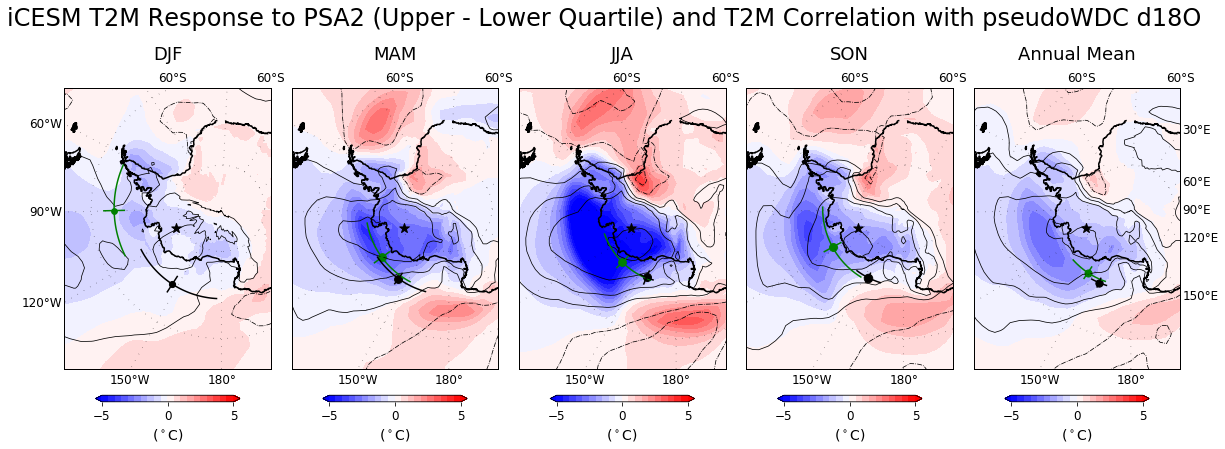

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM T2M Response to PSA2 (Upper - Lower Quartile) and T2M Correlation with pseudoWDC d18O', fontsize=24, y=1.05)

#Remove Pizza slice in variables
djf_t2m_quart_diff_due_to_PSA2_ctrl_fin, lons = addcyclic(djf_t2m_quart_diff_due_to_PSA2_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
mam_t2m_quart_diff_due_to_PSA2_ctrl_fin, lons = addcyclic(mam_t2m_quart_diff_due_to_PSA2_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
jja_t2m_quart_diff_due_to_PSA2_ctrl_fin, lons = addcyclic(jja_t2m_quart_diff_due_to_PSA2_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
son_t2m_quart_diff_due_to_PSA2_ctrl_fin, lons = addcyclic(son_t2m_quart_diff_due_to_PSA2_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
ann_mean_t2m_quart_diff_due_to_PSA2_ctrl_fin, lons = addcyclic(ann_mean_t2m_quart_diff_due_to_PSA2_ctrl.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)
ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin, lons = addcyclic(ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl.pearsons.values, CTRL_DATA.coords['lon'].values, axis=-1, cyclic=361)

# setup Lambert Conformal basemap.
lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
# levels_contour = [-.230,.230] #good for seasons and annual mean
# levels_contour = [-.93,-.83,-.73,-.63,-.53,-.43,-.33,-.23,.23,.33,.43,.53,.63,.73,.83,.93] #adding additional contours
levels_contour = [-1,-.8,-.6,-.4,-.2,.2,.4,.6,.8,1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'dashdot'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_quart_diff_due_to_PSA2_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_quart_diff_due_to_PSA2_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())
                
     
#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_quart_diff_due_to_PSA2_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())        
        
        
        
 #SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_quart_diff_due_to_PSA2_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())


 
#Annual
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_quart_diff_due_to_PSA2_ctrl_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_pseudoWDC_d18O_0002_0076_corr_coef_ctrl_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.abs_vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.abs_vals.mean())    
    
plt.savefig(FIG_PATH+'/Figure_iCESM_Pi_Control_Section_2_Figure_T2M_pseudoWDC_and_PSA2_0002_0076_Multi-Contours_01May2020.ps',bbox_inches='tight', pad_inches=0.02)    
    
#print field variable quart diff at WDC location
print(np.round_(djf_t2m_quart_diff_due_to_PSA2_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(mam_t2m_quart_diff_due_to_PSA2_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(jja_t2m_quart_diff_due_to_PSA2_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(son_t2m_quart_diff_due_to_PSA2_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(ann_mean_t2m_quart_diff_due_to_PSA2_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
    
    
plt.show()